In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

In [63]:
dataset = pd.read_csv('HS300data.csv', sep=',', encoding='gbk')


In [64]:
dataset.head()

,HS300,A股投资者增速,A股换手率,ETF 净赎回力度,融资余额增速,沪深300期指当月溢价率,50ETF PCR,沪深300相对强弱指标,上涨家数占比,情绪指标,Class
0,3190.00,58,69,49.62406,100,95,49.689441,17,26,60.833333,0
1,3067.37,57,60,49.62406,100,97,49.689441,9,4,54.500000,0
2,2836.79,42,47,49.62406,100,99,49.689441,6,15,51.500000,1
3,2868.02,55,59,49.62406,99,37,49.689441,14,44,51.333333,0
4,2768.79,54,47,49.62406,99,17,49.689441,10,14,40.166667,1


In [65]:
from sklearn.model_selection import train_test_split

X, y = dataset.iloc[:, 1:-1].values, dataset.iloc[:, -1].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)

In [66]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train[:,:])
X_test_std = stdsc.transform(X_test[:,:])

In [67]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.3, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):
        
        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, 
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train, 
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

Logistic Regresssion

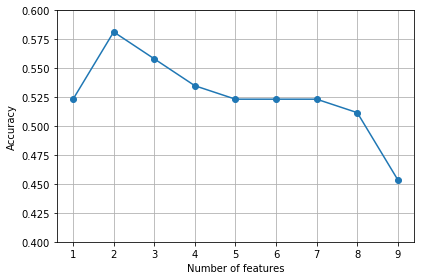

In [68]:
from sklearn.linear_model import LogisticRegression


lr = LogisticRegression(C=100.0, random_state=1)

# selecting features
sbs = SBS(lr, k_features=1)
sbs.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.4, 0.6])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('images/04_08.png', dpi=300)
plt.show()

In [69]:
k2 = list(sbs.subsets_[-2])
k3 = list(sbs.subsets_[-3])
print(dataset.columns[k2])
print(dataset.columns[k3])

Index(['A股换手率', 'ETF 净赎回力度'], dtype='object')
Index(['A股换手率', 'ETF 净赎回力度', '沪深300期指当月溢价率'], dtype='object')


In [70]:
#lr.fit(X_train_std, y_train)
#lr.predict_proba(X_test_std[0, :].reshape(1, -1))

In [71]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

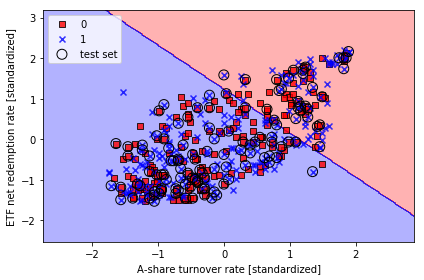

In [72]:
lr.fit(X_train_std[:, k2], y_train)

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X_combined_std, y_combined,
                      classifier=lr, test_idx=range(len(X_train_std), len(X_train_std)+len(X_test_std)))
plt.xlabel('A-share turnover rate [standardized]')
plt.ylabel('ETF net redemption rate [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_15.png', dpi=300)
plt.show()

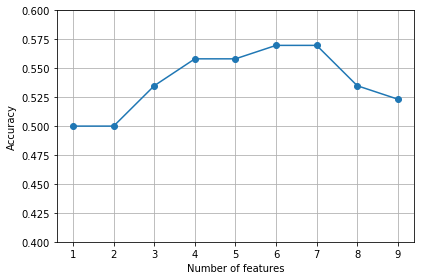

In [73]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', random_state=0, gamma=0.2, C=1.0)

# selecting features
sbs = SBS(svm, k_features=1)
sbs.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.4, 0.6])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('images/04_08.png', dpi=300)
plt.show()

In [74]:
k7 = list(sbs.subsets_[-7])
print(dataset.columns[k7])

Index(['A股投资者增速', 'A股换手率', 'ETF 净赎回力度', '融资余额增速', '沪深300期指当月溢价率', '50ETF PCR',
       '上涨家数占比'],
      dtype='object')


In [79]:
k7_ = np.array(k7)
svm.fit(X_train_std[:,k7_], y_train)
print('Training accuracy:', svm.score(X_train_std[:,k7_], y_train))
print('Test accuracy:', svm.score(X_test_std[:,k7_], y_test))

Training accuracy: 0.729824561404
Test accuracy: 0.544715447154


In [80]:
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [81]:
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import StratifiedKFold
else:
    from sklearn.model_selection import StratifiedKFold
    

if Version(sklearn_version) < '0.18':
    kfold = StratifiedKFold(y=y_train, 
                            n_folds=10,
                            random_state=1)
else:
    kfold = StratifiedKFold(n_splits=10,
                            random_state=1).split(X_train, y_train)
    
    
pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(random_state=1))])


scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1,
          np.bincount(y_train[train]), score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 1, Class dist.: [117 138], Acc: 0.500
Fold: 2, Class dist.: [118 138], Acc: 0.552
Fold: 3, Class dist.: [118 138], Acc: 0.483
Fold: 4, Class dist.: [118 138], Acc: 0.552
Fold: 5, Class dist.: [118 139], Acc: 0.536
Fold: 6, Class dist.: [118 139], Acc: 0.464
Fold: 7, Class dist.: [118 139], Acc: 0.500
Fold: 8, Class dist.: [118 139], Acc: 0.536
Fold: 9, Class dist.: [118 139], Acc: 0.536
Fold: 10, Class dist.: [118 139], Acc: 0.536

CV accuracy: 0.519 +/- 0.029


In [82]:
if Version(sklearn_version) < '0.18':
    kfold = StratifiedKFold(y=y_train, 
                            n_folds=10,
                            random_state=1)
else:
    kfold = StratifiedKFold(n_splits=10,
                            random_state=1).split(X_train, y_train)

pipe_svc = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', SVC(random_state=1))])

scores = []
for k, (train, test) in enumerate(kfold):
    pipe_svc.fit(X_train[train], y_train[train])
    score = pipe_svc.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1,
          np.bincount(y_train[train]), score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold: 1, Class dist.: [117 138], Acc: 0.467
Fold: 2, Class dist.: [118 138], Acc: 0.448
Fold: 3, Class dist.: [118 138], Acc: 0.448
Fold: 4, Class dist.: [118 138], Acc: 0.586
Fold: 5, Class dist.: [118 139], Acc: 0.536
Fold: 6, Class dist.: [118 139], Acc: 0.500
Fold: 7, Class dist.: [118 139], Acc: 0.607
Fold: 8, Class dist.: [118 139], Acc: 0.500
Fold: 9, Class dist.: [118 139], Acc: 0.500
Fold: 10, Class dist.: [118 139], Acc: 0.607

CV accuracy: 0.520 +/- 0.058
